In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''Constants'''
IMAGE_FOLDER = "data/anime wallpapers"

BATCH_SIZE = 1
SCALE = 4
EPOCHS = 35

INPUT_SIZE = Dimensions(1080//4, 1920//4)
OUTPUT_SIZE = Dimensions(INPUT_SIZE.h*SCALE, INPUT_SIZE.w*SCALE)

LEARNING_RATE = 0.01

In [3]:
'''Load data'''
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
num_pngs = len(image_png_names)
num_jpgs = len(image_jpg_names)
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [4]:
def upscaler(in_tensor, in_channels, f_1, f_r, f_u, out_channels):
    upscale_model = Model("Upscaler", in_tensor)
    upscale_model.full_conv2d(3,f_1)
    upscale_model.relu()

    upscale_model.add_residual_block(f_1,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_1,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)

    '''
    upscale_model.upscale([OUTPUT_SIZE.h//2,OUTPUT_SIZE.w//2])
    upscale_model.full_conv2d(f_r,f_u)
    upscale_model.relu()
    '''
    
    upscale_model.upscale([OUTPUT_SIZE.h,OUTPUT_SIZE.w])
    upscale_model.full_conv2d(f_u,f_u)
    upscale_model.relu()
    
    upscale_model.full_conv2d(f_u, 3, mapsize=1)
    upscale_model.rgb_bound()
    upscale_model.reshape([-1,OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])
    return upscale_model

In [5]:
small_train = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
large_train = tf.placeholder('float32', shape = [None, OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])
small_train_flattened = tf.reshape(small_train,[-1, INPUT_SIZE.h*INPUT_SIZE.w*3])
large_train_flattened = tf.reshape(large_train,[-1, OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])


upscale_model = upscaler(small_train, 3, 100, 100, 100, 3)

up_MSE = tf.reduce_mean(tf.square(upscale_model.get_output() - large_train_flattened))
up_loss = up_MSE
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(up_loss,var_list=upscale_model.variables)
pred = tf.reshape(tf.cast(upscale_model.get_output(), dtype=tf.uint8),[-1,OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])

init = tf.initialize_all_variables()

In [6]:
image_gen = minibatch_image_generator(image_png_paths[0:1],BATCH_SIZE)

In [7]:
sess = tf.Session()
sess.run(init)

In [8]:
print("generating images")
epoch,image_batch = next(image_gen)
in_image = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w], interp='bicubic') for img in image_batch])
out_image = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w], interp='bicubic') for img in image_batch])
print("generated images") 

generating images
generated images


In [9]:
len(image_png_paths)

1225

In [ ]:
try:
    index = 0
    epoch = 0
    while epoch < 800:
        index += 1
        (_) = sess.run([optimizer], feed_dict={small_train:in_image, large_train:out_image})
        epoch,image_batch = next(image_gen)
        in_image = np.array([scipy.misc.imresize(img, [INPUT_SIZE.h, INPUT_SIZE.w]) for img in image_batch])
        out_image = np.array([scipy.misc.imresize(img, [OUTPUT_SIZE.h, OUTPUT_SIZE.w]) for img in image_batch])
        if(index % 20 == 0):
            (mse) = sess.run(up_loss, feed_dict={small_train:in_image, large_train:out_image})
            print('epoch = %-5d step = %-5d mse = %-10f' % (epoch, index, mse))

    (sample) = sess.run(pred,feed_dict={small_train:in_image, large_train:out_image})
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

epoch = 20    step = 20    mse = 6908.438477
epoch = 40    step = 40    mse = 5702.178223


In [11]:
out_gen = minibatch_image_generator(image_png_paths[0:1],BATCH_SIZE)

_,test_batch = next(out_gen)
in_image_t = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w], interp='bicubic') for img in test_batch])
out_image_t = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w], interp='bicubic') for img in test_batch])

In [12]:
(sample) = sess.run(pred,feed_dict={small_train:in_image_t})

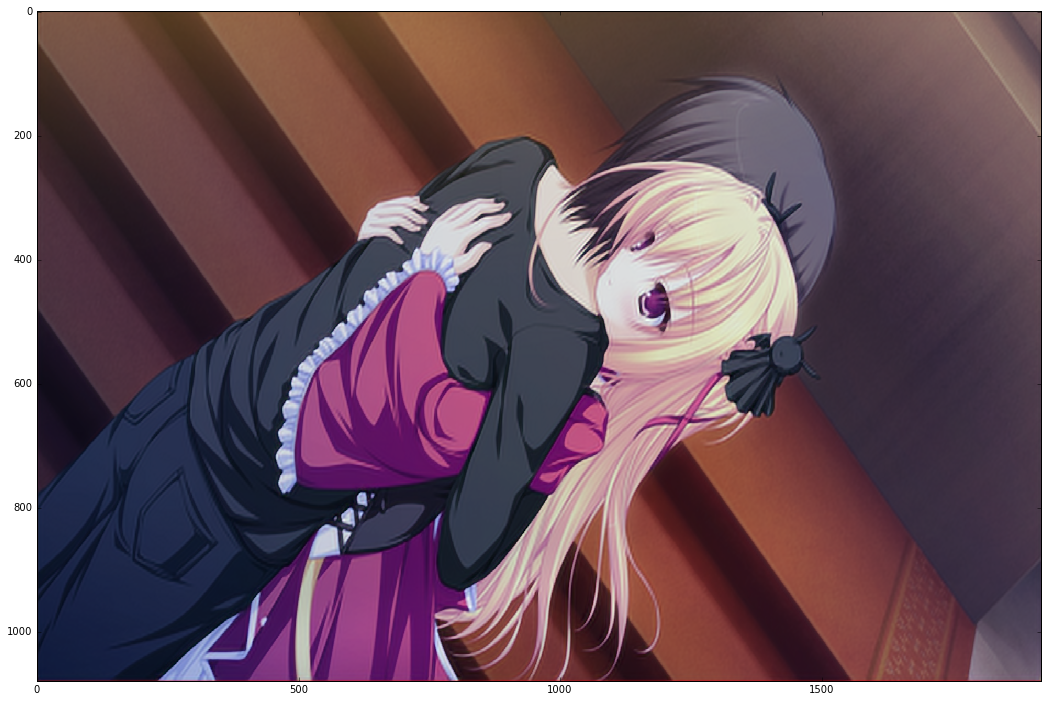

In [13]:
plt.figure(figsize = (18,12))
plt.imshow(sample[0],interpolation='nearest', aspect='auto')

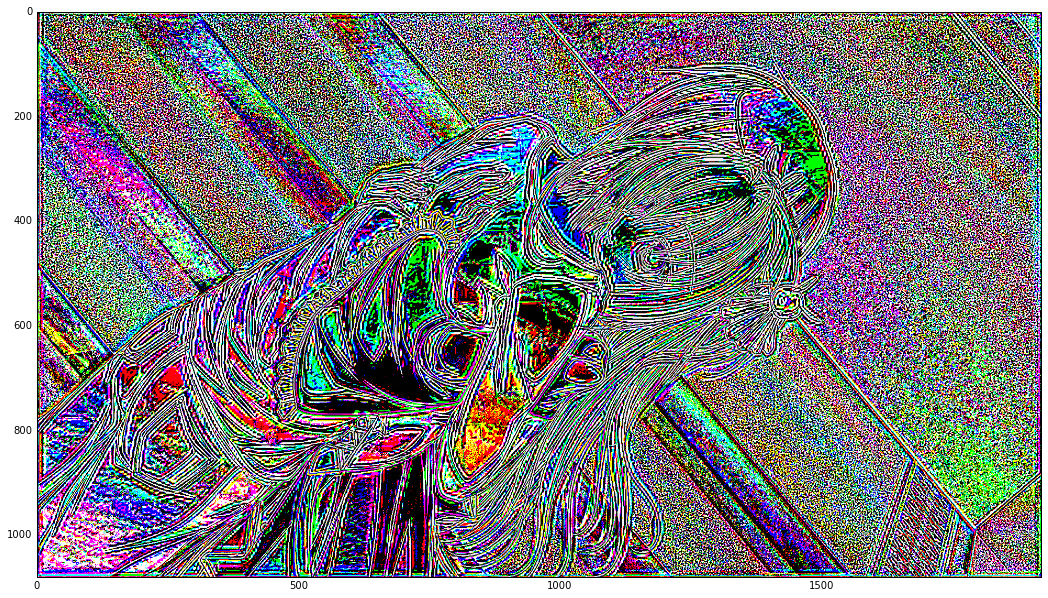

In [14]:
plt.figure(figsize = (18,12))
shape = sample[0].shape
diff_flat = abs(np.reshape(sample[0]-out_image_t[0],[-1]))
diff = np.reshape(diff_flat,shape)
plt.imshow(diff)

In [ ]:
flat = np.reshape(out_image_t[0],[-1])
min(flat)

In [15]:
output_number = 28
rezoomed = misc.imresize(in_image[0],[OUTPUT_SIZE.h, OUTPUT_SIZE.w])
#output_number = output_number + 1
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_output.png", sample[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_input.png", in_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_original.png", out_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_diff.png", sample[0]-out_image_t[0])
print("Created images with number = "+str(output_number))

Created images with number = 28


In [ ]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.VARIABLES))
saver.save(sess, '../saves', global_step=1)

In [ ]:
saver.restore(sess,'../saves-1')

In [13]:
#Clears everything
sess.close()
tf.reset_default_graph()